

> Suicide and depression detection in Reddut messages




Connect google

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! ls -s /content/gdrive/MyDrive/SuicideAndDepressionDetection

total 162991
162991 Suicide_Detection.csv


Imports


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

### **READ THE DATA**

---



In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/SuicideAndDepressionDetection/Suicide_Detection.csv", header = None, names = ["index", "text", "class"])
df.head()

,index,text,class
0,NaN,text,class
1,2.0,Ex Wife Threatening SuicideRecently I left my ...,suicide
2,3.0,Am I weird I don't get affected by compliments...,non-suicide
3,4.0,Finally 2020 is almost over... So I can never ...,non-suicide
4,8.0,i need helpjust help me im crying so hard,suicide


In [ ]:
len(df)

232075

In [ ]:
df["class"]

0               class
1             suicide
2         non-suicide
3         non-suicide
4             suicide
             ...     
232070    non-suicide
232071    non-suicide
232072    non-suicide
232073        suicide
232074    non-suicide
Name: class, Length: 232075, dtype: object

Less data than original because session crashed :/

In [ ]:
input_size = int(len(df)/7)
input_size

33153

In [ ]:
reddit_paths = df.loc[1:input_size, "index"].tolist()
reddits = df.loc[1:input_size, "text"].tolist()
reddit_class = df.loc[1:input_size, "class"].tolist()

In [ ]:
len(reddit_paths)

33153

In [ ]:
print(reddits[1])
reddit_class[1]

Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it


'non-suicide'

## PREPROCESSING


---



###Removed stop words

Corpus will contain reddits, but without stop words

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
corpus = []
for sentence in reddits:
  words = sentence.split(" ")
  filtered_words = [word.lower() for word in words if not word in stopwords]
  corpus.append(" ".join(filtered_words))
corpus

In [ ]:
print(stopwords)

{'there', 'o', 'under', 'further', "aren't", 'shouldn', 'aren', 'myself', 'mustn', 'doing', 'shan', 'very', 'didn', "mightn't", 'but', 'once', 've', 'now', 'into', 'who', 'so', 'too', 'itself', 'am', 'such', 'will', 'doesn', 'wasn', 'on', 'are', 'did', 'between', "you'll", 'any', 'some', "haven't", 'have', "couldn't", 'in', "don't", 'over', 's', 'during', 'yours', 'the', 'ain', "doesn't", 'here', 'nor', 'you', 'more', 'being', 'each', 'of', 'been', 'while', 'yourself', 'same', 'don', "won't", 'them', 'ours', 'both', 'how', 'where', 'couldn', 'had', "should've", 'your', 'after', 'my', 'she', 'these', "you're", 'he', 'do', "you've", 'against', 'were', 'mightn', 'through', 'above', 'be', 'was', 'won', 'haven', 'm', 'hasn', 'theirs', 'because', 'with', 're', 'isn', "it's", 'just', 'ourselves', "wouldn't", 'out', 'y', 'that', 'again', 'all', "she's", 'other', 'himself', 'and', 'as', 'few', 'does', 'him', 'whom', 'by', 'not', "hadn't", 't', 'off', 'what', 'own', "needn't", 'our', 'if', 'we',

In [ ]:
corpus[2]

In [ ]:
reddits[2]

##### **CLEANING THE TEXT**



1.   Lowercase reddits
2.   Remove whitespace
3.   Remove numbers
4.   Remove special characters
5.   Remove emails
6.   Remove stop words
7.   Remove NAN
8.   Remove links
9.   Tokenize:
Tokenization refers to the process of breaking down a text or document into smaller units called tokens. Tokens can be individual words, sentences, or even smaller units like characters or subwords, depending on the specific tokenization scheme used.




In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleanText(text):
  text = str(text)
  text = text.lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url = re.sub(r'http\S+', '', cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words = [stemmer.stem(w) for w in filtered_words]
  lemma_words = [lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)

In [ ]:
df['text'][1:input_size]

1        Ex Wife Threatening SuicideRecently I left my ...
2        Am I weird I don't get affected by compliments...
3        Finally 2020 is almost over... So I can never ...
4                i need helpjust help me im crying so hard
5        I’m so lostHello, my name is Adam (16) and I’v...
                               ...                        
33148    My Manifesto - A Conversation with My Only Fri...
33149    I've been trying so hard to fix things, but I ...
33150    my dad is actually smart asf he looked at this...
33151    My life doesn't matterI will just be another n...
33152    I am so tired of thisI keep thinking about sui...
Name: text, Length: 33152, dtype: object

In [ ]:
len(df['text'][0:input_size])

33153

In [ ]:
df['text'][1]

"Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen."

In [ ]:
df['cleanText'] = df['text'][1:input_size].map(lambda s:cleanText(s))

In [ ]:
cleanReddits = df['cleanText'][0:input_size]
len(cleanReddits)

KeyError: ignored

In [ ]:
cleanReddits = df.loc[1:input_size, "cleanText"].tolist()
len(cleanReddits)

33153

In [ ]:
input_size

33153

In [ ]:
cleanReddits[71]

'anyone planning suicide long term future depressed considering suicide soon within maybe years want kill kind long story main reasons combination lack economic stability health problems family along lack purpose inherent value life economic growing hard overcome lot adversity lower income household mother dying young age queer person color strict parents depression etc like lot people college currently found although genuinely love learning picked stem major college seems oppressive know makes sound like entitled first world millenial parents made flagship state school directly high school allowing choose different school even years relatively good grades high school knew moment campus hated lack diversity friendship health negatively impacted good sense direction idea major career never felt inspired thought transferring resources finances first generation college student stuck though depressed well academically since major department kinda shitty applied math worried get good paying

In [ ]:
reddits[71]

'Anyone planning suicide in the long-term future?I\'m a depressed 22F who is considering suicide, but not soon, but within maybe 4-5 years.\nWhy do I want to kill myself?\nIt\'s kind of a long story. But the main reasons are a combination: (Lack of) Economic Stability, Health Problems, Family\nalong with a lack of purpose or inherent value of life.\n\n**Economic**:\n\nGrowing up was hard and I\'ve had to overcome a lot of adversity (lower-income household, mother dying at\na young age, being a queer person of color, strict parents, depression etc), like a lot of people here.\nI\'m in college currently, but found that although I genuinely love learning and picked a STEM major, college \njust seems very oppressive. I know it makes me sound like an entitled, first world millenial.\nMy parents made me go the flagship state school directly after high school, not allowing me to choose a different school\nor even CC for a few years (I had relatively good grades in high school). I knew from th

In [ ]:
reddit_class[71]

'suicide'

### NER(Named Entity Recognition)

is a subtask of info extraction that aims to identify and classify named entities within text into predefined categories such as person names, location or organization.

In [ ]:
txt = cleanReddits

**Spacy information**

spacy.load("en_core_web_sm") is a Python code snippet that loads a specific language model in spaCy, which is a popular open-source library used for natural language processing (NLP) tasks.

In this case, "en_core_web_sm" refers to the name of the English language model provided by spaCy. The model is trained on a large corpus of English text and contains pre-trained word vectors, linguistic annotations, and various NLP features.

By executing spacy.load("en_core_web_sm"), you are loading the English language model into memory, allowing you to perform various NLP tasks such as tokenization, part-of-speech tagging, named entity recognition, dependency parsing, and more.

In [ ]:
import spacy
from spacy import displacy
spacy.load("en_core_web_sm")

Test just for one to see how it works

In [ ]:
txt = cleanReddits[1]
tokenizer = spacy.load("en_core_web_sm")
adj=[]
token_list = tokenizer(txt)
for token in token_list:
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))
    if (token.pos_ == 'ADJ'):
      adj.append(token)

weird JJ ADJ adjective (English), other noun-modifier (Chinese)
get VBP AUX verb, non-3rd person singular present
affected VBN VERB verb, past participle
compliments NNS NOUN noun, plural
coming VBG VERB verb, gerund or present participle
someone NN PRON noun, singular or mass
know VBP VERB verb, non-3rd person singular present
irl NN NOUN noun, singular or mass
feel VBP VERB verb, non-3rd person singular present
really RB ADV adverb
good JJ ADJ adjective (English), other noun-modifier (Chinese)
internet NN NOUN noun, singular or mass
strangers NNS NOUN noun, plural


ADJ in cleaned ds

In [ ]:
tokenizer = spacy.load("en_core_web_sm")
adj = []
for redd in range((len(cleanReddits)-1)):
  txt = cleanReddits[redd]
  token_list = tokenizer(txt)
  for token in token_list:
    if (token.pos_ == 'ADJ'):
      adj.append(token)


In [ ]:
adj

In [ ]:
tokenizer = spacy.load("en_core_web_sm")
token_list = tokenizer(txt)
for token in token_list.ents:
    print(token.text, '->', token.label_)

night -> TIME


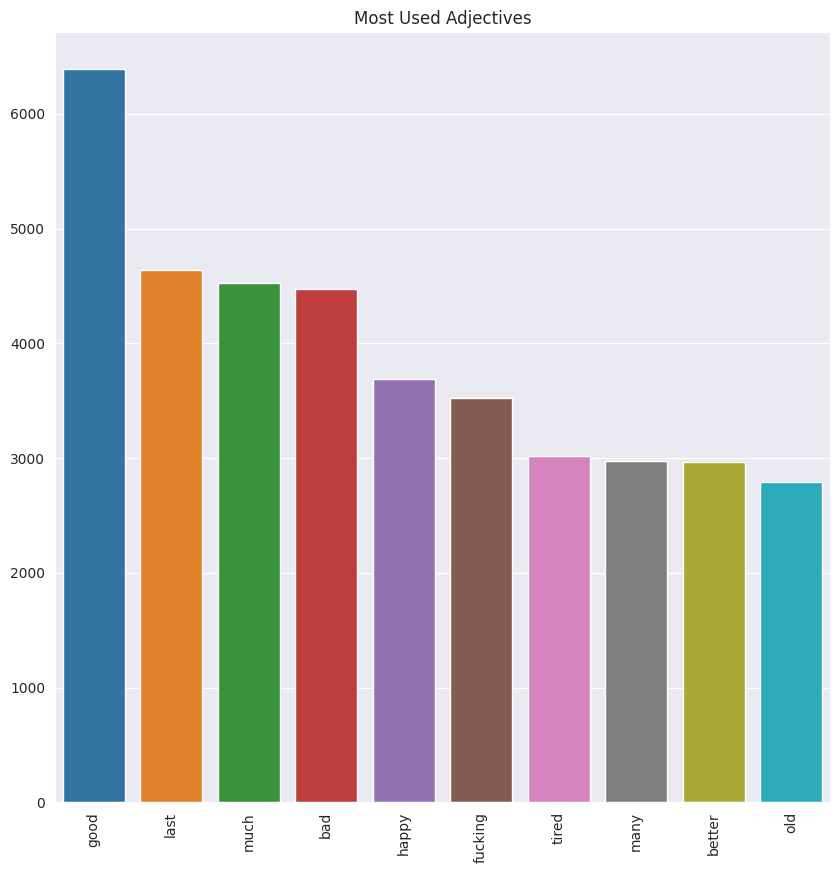

In [ ]:
import os
from collections import Counter
import seaborn as sns

adjectives = ' '.join(map(str, adj))

d = os.getcwd()
freq = Counter(adjectives.split(" "))
sns.set_style("darkgrid")
words = [word[0] for word in freq.most_common(10)]
count = [word[1] for word in freq.most_common(10)]

plt.figure(figsize=(10, 10))

sns_bar = sns.barplot(x=words, y=count)
sns_bar.set_xticklabels(words, rotation=90)
plt.title('Most Used Adjectives')
plt.show()


*   reddit_paths -> indexes for all reddits -> df['index']
*   reddits -> reddits before preprocessing -> df['text']
*   reddit_class -> labels ( bool ) -> df['class']
*   cleanReddits -> cleanText -> df['cleanText']



### Most common ADJ in suicidal/depressive reddits vs most common ADJ in non-suicidal/ depressive reddits

In order to see this, I will need to split my data into suicidal and non suicidal reddits based on their labels.

In [ ]:
suicidal = []
non_suicidal = []
# Don't actually think this is needed as the suicidal_verdict will always be 1, and nonsuicidal_verdict will always be 0
suicidal_verdict = []
nonsuicidal_verdict = []

# I am using zip(cleanReddits, reddit_paths) because I don't want to mess up the labels, so I am taking them in pairs
for phrase, verdict  in zip(cleanReddits, reddit_class):
  if int(verdict == "suicide"):
    suicidal.append(phrase)
    suicidal_verdict.append(verdict)
  else:
    non_suicidal.append(phrase)
    nonsuicidal_verdict.append(verdict)

In [ ]:
suicidal[1]

'need helpjust help crying hard'

Most common ADJ in suicidal

In [ ]:
tokenizer = spacy.load("en_core_web_sm")
suicidal_adj = []
for redd in range((len(suicidal)-1)):
  txt = suicidal[redd]
  token_list = tokenizer(txt)
  for token in token_list:
    if (token.pos_ == 'ADJ'):
      suicidal_adj.append(token)


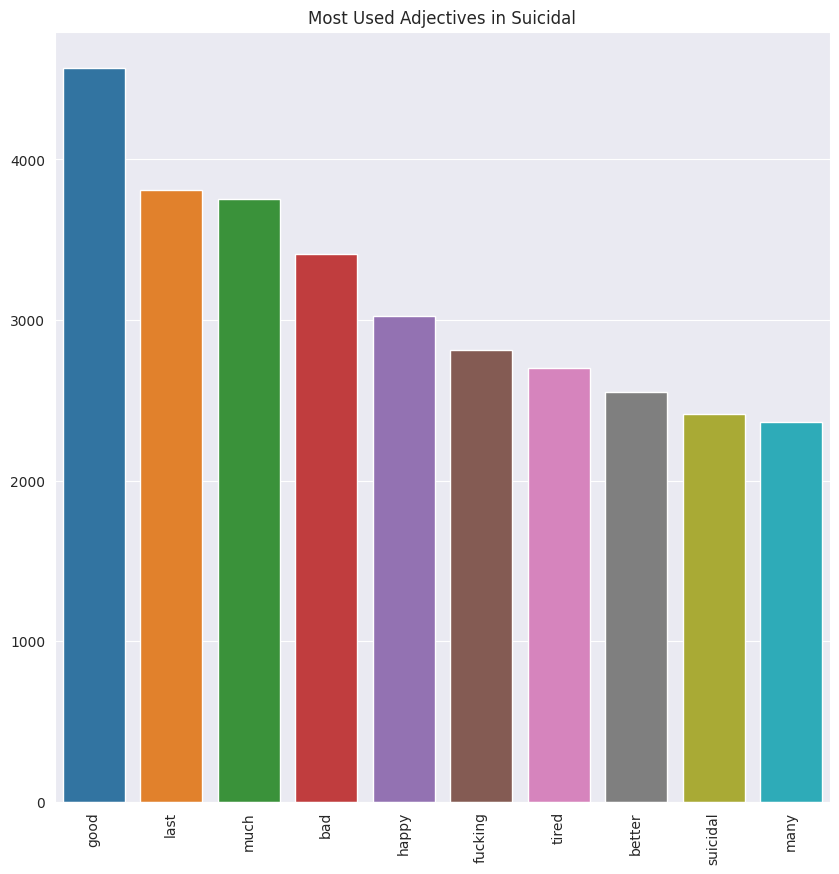

In [ ]:
import os
from collections import Counter
import seaborn as sns

suicidal_adjectives = ' '.join(map(str, suicidal_adj))

d = os.getcwd()
freq = Counter(suicidal_adjectives.split(" "))
sns.set_style("darkgrid")
words = [word[0] for word in freq.most_common(10)]
count = [word[1] for word in freq.most_common(10)]

plt.figure(figsize=(10, 10))

sns_bar = sns.barplot(x=words, y=count)
sns_bar.set_xticklabels(words, rotation=90)
plt.title('Most Used Adjectives in Suicidal')
plt.show()

Most Common Used in Non-Suicidal

In [ ]:
tokenizer = spacy.load("en_core_web_sm")
non_suicidal_adj = []
for redd in range((len(non_suicidal)-1)):
  txt = non_suicidal[redd]
  token_list = tokenizer(txt)
  for token in token_list:
    if (token.pos_ == 'ADJ'):
      non_suicidal_adj.append(token)

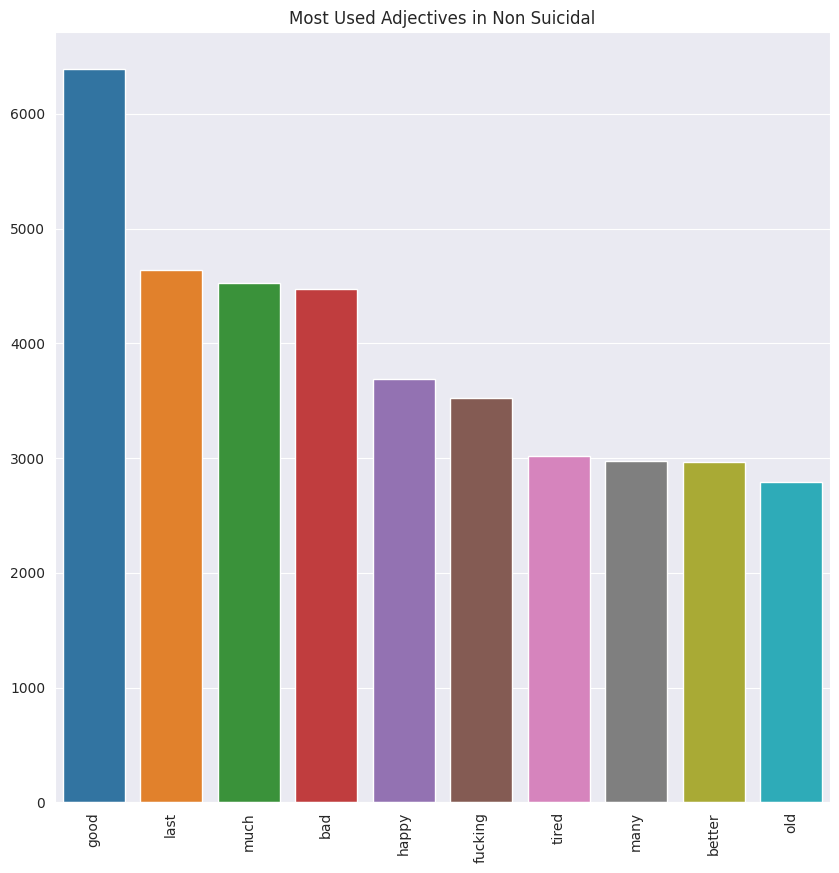

In [ ]:
import os
from collections import Counter
import seaborn as sns

non_suicidal_adjectives = ' '.join(map(str, non_suicidal_adj))

d = os.getcwd()
freq = Counter(adjectives.split(" "))
sns.set_style("darkgrid")
words = [word[0] for word in freq.most_common(10)]
count = [word[1] for word in freq.most_common(10)]

plt.figure(figsize=(10, 10))

sns_bar = sns.barplot(x=words, y=count)
sns_bar.set_xticklabels(words, rotation=90)
plt.title('Most Used Adjectives in Non Suicidal')
plt.show()

### COUNT VECTORIZER

* We are using count vectorizer to implement BoW model



****Count Vectorizer****
Countvectorizer makes it easy for text data to be used directly in machine learning and deep learning models such as text classification. I have 2 text inputs, what happens is that each input is preprocessed, tokenized, and represented as a sparse matrix.



1.   *CountVectorizer* is a text preprocessing class in scikit-learn that is used to convert a collection of text documents into a matrix of token counts.
2.   **vect.fit(reddits)**: The fit() method is called on the CountVectorizer object (vect), and it is passed the variable reddits. This method analyzes the given text data (reddits) and builds an internal vocabulary, which is essentially a dictionary of unique words (or tokens) found in the text corpus. It learns the vocabulary from the provided data.
3. **vect.transform(reddits).toarray()**: This line transforms the given text data (reddits) into a matrix of token counts. The transform() method takes the text data and converts it into a numerical feature representation. The resulting output is a sparse matrix representation of the token counts. The toarray() method is then called on the sparse matrix to convert it into a regular NumPy array.



*   reddit_paths -> indexes for all reddits -> df['index']
*   reddits -> reddits before preprocessing -> df['text']
*   reddit_class -> labels ( bool ) -> df['class']
*   cleanReddits -> cleanText -> df['cleanText']
*   suicidal -> suicidal reddits
*   non_suicidal -> non suicidal reddits

After preproceesing some reddits were nan, so I needed to eliminate them from the list for vectorization - Prove to be of no need after all. This issue was fixed by adding the following line below

vectorized_reddits = df.loc[1:input_size, "cleanText"].astype(str).tolist()

In [ ]:
len(cleanReddits)

33153

In [ ]:
cleanReddits = df.loc[1:input_size, "cleanText"].astype(str).tolist()

In [ ]:
len(cleanReddits)

33153

*   reddit_paths -> indexes for all reddits -> df['index']
*   reddits -> reddits before preprocessing -> df['text']
*   reddit_class -> labels ( bool ) -> df['class']
*   cleanReddits -> cleanText -> df['cleanText']
*   cleanLabels -> labels after exclusion of nan reddits
*   suicidal -> suicidal reddits
*   non_suicidal -> non suicidal reddits

In [ ]:
vectorized_reddits = df.loc[1:input_size, "cleanText"].astype(str).tolist()

In [ ]:
len(vectorized_reddits)

33153

In [ ]:
vectorized_reddits

vect =  CountVectorizer()
vect.fit(vectorized_reddits)
vect.transform(vectorized_reddits).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

There are a total of 33153 reddit posts proposed for analysis.

The vector vocabulary as 48921 unique words.

In [ ]:
len(vect.transform(vectorized_reddits).toarray())

33153

In [ ]:
vectorized_reddits


In [ ]:
# Unique words
print("Vocabulary size: {}".format(len(vect.vocabulary_)))

# Assigned index of words ( index into array/ list )
print("Vocabulary content:\{}".format(vect.vocabulary_))

Vocabulary size: 48921
Vocabulary content:\{'wife': 47283, 'threatening': 42858, 'suiciderecently': 41151, 'left': 24307, 'good': 18071, 'cheated': 6949, 'twice': 44368, 'lied': 24536, 'much': 27781, 'decided': 10354, 'refuse': 34856, 'back': 3416, 'days': 10156, 'ago': 1063, 'began': 4083, 'suicide': 41113, 'tirelessly': 43189, 'spent': 39663, 'paat': 30492, 'talking': 41848, 'keeps': 23445, 'hesitating': 19806, 'wants': 46588, 'believe': 4159, 'come': 7968, 'know': 23735, 'lot': 25259, 'people': 31235, 'threaten': 42856, 'order': 29926, 'get': 17627, 'way': 46744, 'happens': 19100, 'really': 34413, 'supposed': 41366, 'handle': 19025, 'death': 10268, 'hands': 19037, 'still': 40329, 'love': 25294, 'cannot': 6217, 'deal': 10249, 'getting': 17639, 'constantly': 8610, 'feeling': 15472, 'insecure': 21993, 'worried': 47721, 'today': 43292, 'may': 26118, 'day': 10132, 'hope': 20340, 'happen': 19084, 'weird': 46919, 'affected': 878, 'compliments': 8227, 'coming': 8014, 'someone': 39245, 'irl'

In [ ]:
sorted_vocabulary = sorted(vect.vocabulary_.items(), key=lambda x: x[0])
sorted_vocabulary[44101]

('trolololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololololol

### BoW implementation on data set


First we need to split the data for training and testing as follows:

* 75% for training
* 25% for testing

I am adding this notes from time to time during my projects as I don't want to mess up anything

*   reddit_paths -> indexes for all reddits -> df['index']
*   reddits -> reddits before preprocessing -> df['text']
*   reddit_class -> labels ( bool ) -> df['class']
*   cleanReddits -> cleanText -> df['cleanText']
*   cleanLabels -> labels after exclusion of nan reddits
*   suicidal -> suicidal reddits
*   non_suicidal -> non suicidal reddits

+ nOfRedditsForTest -> number of reddits that are for test purpose
+ trainingReddits

Transform the labels as True or False Values

In [ ]:
cleanLabels = []
for i in reddit_class:
  if i == 'suicide':
    cleanLabels.append(1)
  else:
    cleanLabels.append(0)



In [ ]:
len(cleanLabels)

33153

Checked if all conversion from suicide, non-suicide to 1 and 0 went good

In [ ]:
f = 1
for i,x in zip(cleanLabels, reddit_class):
    correct = 0
    if i == 1 and x == 'suicide':
      correct = 1
    if i == 0 and x == 'non-suicide':
      correct = 1
    if correct == 0:
      f = 0
print(f)

1


In [ ]:
nOfRedditsForTest = 8289

print("Number of reddits : ", len(cleanReddits))
print("Number of vect_vocabulary: ", len(vect.vocabulary_))
print("Number of tests: ", nOfRedditsForTest)

trainingReddits = cleanReddits[0:(len(cleanReddits)-nOfRedditsForTest)]
testingReddits = cleanReddits[(len(cleanReddits)-nOfRedditsForTest):]

trainingLabels = reddit_class[0:(len(cleanReddits)-nOfRedditsForTest)]
testingLabels = reddit_class[(len(cleanReddits)-nOfRedditsForTest):]


print("Number of reddits for training" , len(trainingReddits))
print("Number of labels for training" , len(trainingLabels))

print("Number of reddits for testing" , len(testingLabels))
print("Number of labels for testing " , len(testingLabels))

Number of reddits :  33153
Number of vect_vocabulary:  48921
Number of tests:  8289
Number of reddits for training 24864
Number of labels for training 24864
Number of reddits for testing 8289
Number of labels for testing  8289


In [ ]:
len(testingReddits)

In [ ]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
len(trainingReddits)

24864

In [ ]:
print(cleanReddits[5])

print(trainingReddits[5])
print(trainingLabels[5])

print(testingReddits[1])
print(trainingLabels[1])

honetly idki dont know even feel like nothing nowhere feel either nothing unbearably sad ignoring friends every opitunity feel like loosing girlfriend hurt everyone talk dont cause anything good behind education feel alone first time feeling ive enjoyed hopes dreams care nothing family friends even girlfriend still love complicated dont words describe would something end know strong brave enough knowing weak makes sadder thing push away emotion empty bad used way normal dont understand people hopes dreams mentioned bad feeling girlfriend got scared would die havnt brought talk realised cant even comprehend life meaning anyone know rambling probably regret posting ill think taking place someone worse time gun head encoage people see help instead ill probably suvive might plus life meaningless future bleak could cure cancer something useful sorry wasting time
honetly idki dont know even feel like nothing nowhere feel either nothing unbearably sad ignoring friends every opitunity feel lik

x_train -> reddits for training
x_test -> reddits for testing

y_train -> labels corresponding to train
y_test -> labels corresponding to test

In [ ]:
print(type(cleanLabels))

<class 'list'>


In [ ]:
print(type(reddit_class))

<class 'list'>


In [ ]:
# Shuffle the data

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

x = vect.transform(cleanReddits).toarray()
y = np.array(cleanLabels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 2, shuffle = True)

In [ ]:
len(x_train)

24864

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(24864, 48921)
(8289, 48921)
(24864,)
(8289,)


In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

24864
24864
8289
8289


# svM


In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# C coeficient de regularizare (hiperparam)
model = svm.LinearSVC(C=0.1)
# observati convergence warning
model.fit(x_train, y_train)
tpreds = model.predict(x_test)

print(accuracy_score(y_test, tpreds))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9083122210158041


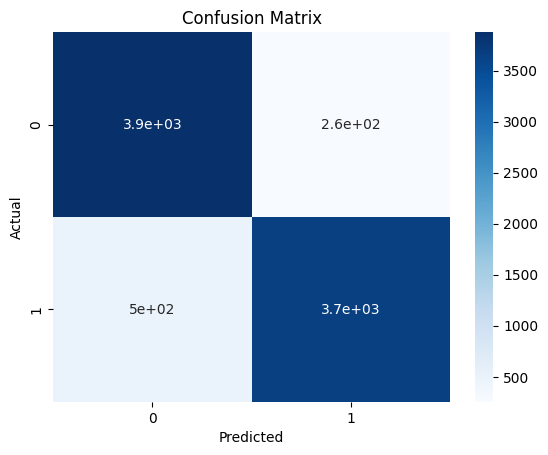

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Create confusion matrix
cm = confusion_matrix(y_test, tpreds)
# Define labels for the plot
labels = np.unique(y_test)
# Create heatmap
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Calculate F1 score

In [ ]:
f1 = f1_score(y_test, tpreds)
print("F1 Score:", f1)

F1 Score: 0.8476693897164825


Some tests:

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=0.1: 0.9083122210158041


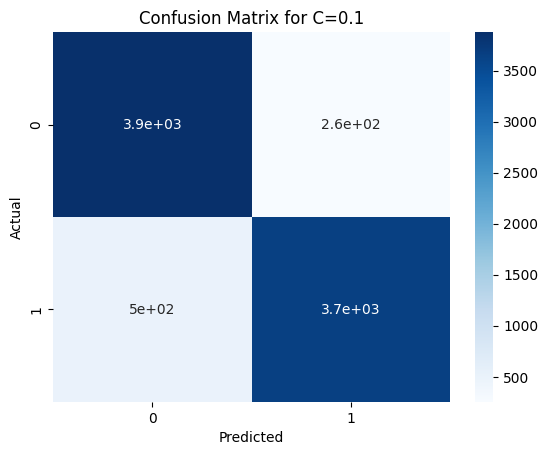

F1 Score for C=0.1: 0.9082377029649542



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=1: 0.8979370249728555


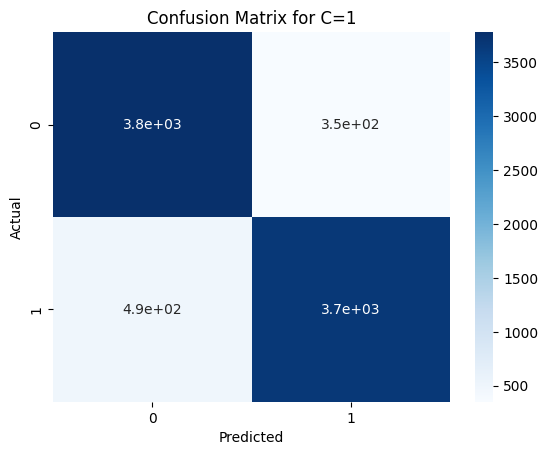

F1 Score for C=1: 0.8979119183227805



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=10: 0.8721196766799373


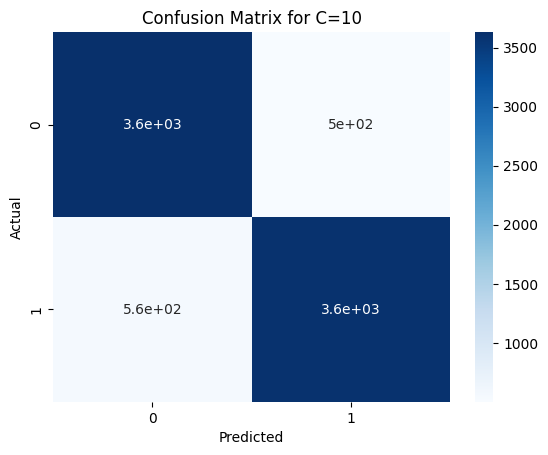

F1 Score for C=10: 0.8721162370771138



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=100: 0.8536614790686452


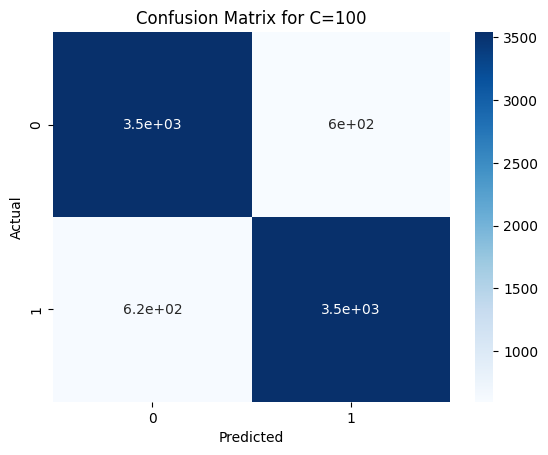

F1 Score for C=100: 0.853661696316142



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy for C=1000: 0.8483532392327181


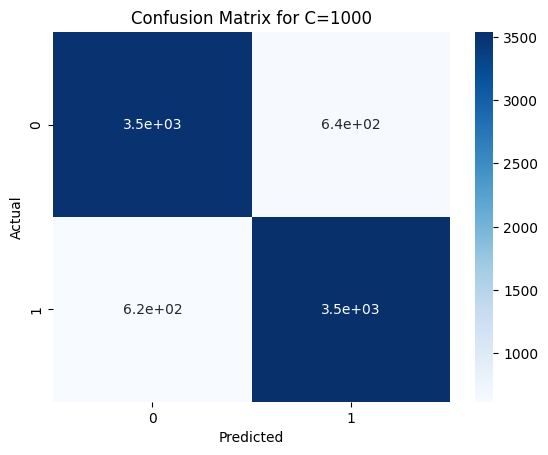

F1 Score for C=1000: 0.8483514778939253



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Define a list of regularization coefficients to test
regularization_coefficients = [0.1, 1, 10, 100, 1000]

for C in regularization_coefficients:
    # C coefficient of regularization (hyperparameter)
    model = svm.LinearSVC(C=C)
    # observe convergence warning
    model.fit(x_train, y_train)
    tpreds = model.predict(x_test)

    accuracy = accuracy_score(y_test, tpreds)
    print("Accuracy for C={}: {}".format(C, accuracy))

    # Create confusion matrix
    cm = confusion_matrix(y_test, tpreds)
    # Define labels for the plot
    labels = np.unique(y_test)
    # Create heatmap
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for C={}".format(C))
    plt.show()

    # Calculate and print F1 score
    f1 = f1_score(y_test, tpreds, average='weighted')
    print("F1 Score for C={}: {}".format(C, f1))
    print()


We tested several coefficients to see which one is a better fit on our SVC for our data.

The smaller the coeficient, the gratest the accuracy.

On our first try we have received the following warning message:  usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn

This suggests that model did not converge with the default number ofinterations, meaning that for an optimal solution we will need to increas the number of iterations. This might help.



In [ ]:
print(accuracy_values)

[0.9083122210158041, 0.8979370249728555, 0.8729641693811075, 0.8524550609241163, 0.8481119556038123]


In [ ]:
l = [0.01, 0.1, 1, 10, 100, 1000]
coefficients = []
accuracy_scores = []

for coefficient in l:
  model = svm.LinearSVC(C=coefficient)
  model.fit(x_train, y_train)
  tpreds = model.predict(x_test)
  accuracy = accuracy_score(y_test, tpreds)
  accuracy_scores.append(accuracy)
  coefficients.append(str(coefficient))
  print( ' coefficient: ' ,  coefficient ,  'accuracy score: ', accuracy)


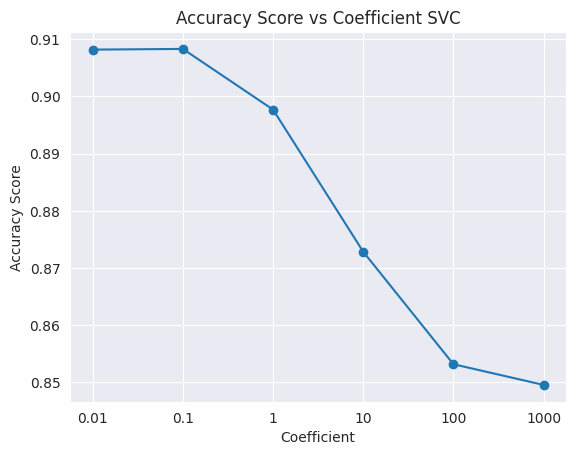

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score

plt.plot(coefficients, accuracy_scores, marker='o')
plt.xlabel('Coefficient')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs Coefficient SVC')
plt.grid(True)
plt.show()

Trying to fix the convergence warning by adding a max_iter param and set it to 10000

In [ ]:
l = [0.01, 0.1, 1, 10, 100, 1000]
coefficients = []
accuracy_scores = []

for coefficient in l:
  model = svm.LinearSVC(C=coefficient, max_iter=10000)
  model.fit(x_train, y_train)
  tpreds = model.predict(x_test)
  accuracy = accuracy_score(y_test, tpreds)
  accuracy_scores.append(accuracy)
  coefficients.append(str(coefficient))
  print( ' coefficient: ' ,  coefficient ,  'accuracy score: ', accuracy)

 coefficient:  0.01 accuracy score:  0.9081915792013512
 coefficient:  0.1 accuracy score:  0.9083122210158041
 coefficient:  1 accuracy score:  0.8979370249728555


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 coefficient:  10 accuracy score:  0.8728435275666546


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 coefficient:  100 accuracy score:  0.8495596573772469


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


 coefficient:  1000 accuracy score:  0.8379780431897695


# SVC

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.svm import SVC
model = SVC()

model.fit(x_train, y_train)

predictions = model.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4133
           1       0.95      0.77      0.85      4156

    accuracy                           0.86      8289
   macro avg       0.88      0.86      0.86      8289
weighted avg       0.88      0.86      0.86      8289



# Using GridSearchCV

One of the great things about GridSearchCV is that it is a meta-estimator. It takes an estimator like SVC and creates a new estimator, that behaves exactly the same – in this case, like a classifier. You should add refit=True and choose verbose to whatever number you want, the higher the number, the more verbose (verbose just means the text output describing the process).

* https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

# Gaussian NB

Gaussian NB classifre + train model ( clf )

In [ ]:
n_estimators = [10, 1000, 3000, 10.0]
clf = RandomForestClassifier(n_estimators=3000)

clf.fit (x_train,y_train)

y_pred=clf.predict(x_test)

from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8884063216310774


# NN

I am adding this notes from time to time during my projects as I don't want to mess up anything

*   reddit_paths -> indexes for all reddits -> df['index']
*   reddits -> reddits before preprocessing -> df['text']
*   reddit_class -> labels ( bool ) -> df['class']
*   cleanReddits -> cleanText -> df['cleanText']
*   cleanLabels -> labels after exclusion of nan reddits
*   suicidal -> suicidal reddits
*   non_suicidal -> non suicidal reddits

+ nOfRedditsForTest -> number of reddits that are for test purpose
+ trainingReddits

Some imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

1.  Using RaggedTensor because it is hard to train a NN to handle sentences of different lengths, so I will use padded sequences.
2.  The desired length will be specified by using maxlen

3. The sentences longer than maxlen will be truncated post or pre-truncation

In [ ]:
vocab_size = len(vect.vocabulary_)

In [ ]:
vocab_size = int(vocab_size)
vocab_size

48921

In [ ]:
# Plot as having good and bad in opposite direction, and i will plot things after. Plot in xy axes and start to determine the good and bad

# Top layer = embedding, where direction of each word will be learned epoch by epoch
# Pull global avarage
embedding_dim = 16
max_length = 100
model = tf.keras.Sequential([
                            # learn epoch by epoch
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length= max_length),
                             # Pool with a global avarage pooling
                             # adding up the vectors ( as described above )
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(24, activation= 'relu'),
                             tf.keras.layers.Dense(1, activation= 'sigmoid')
])
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [ ]:
# RaggedTensor -when I need to train a nn to handle sentences of different lengths
# For now I will use padded sequences
# I can also specify the desired length using maxlen
# What happens with sentences longer than maxlen: They are truncated post or pre-truncation
oov_tok = "<OOV>"
import torch
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= vocab_size, oov_token= oov_tok)
# create tokens for every word in the corpus
tokenizer.fit_on_texts(cleanReddits)

word_index = tokenizer.word_index

# turn sentences into sequences of tokens and pad them to the same length
training_sequences = tokenizer.texts_to_sequences(trainingReddits)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding= 'post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(testingReddits)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 30

history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), verbose=2)

# Extract training and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Generate x-axis values for epochs
epochs = range(1, num_epochs + 1)

# Plotting the loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

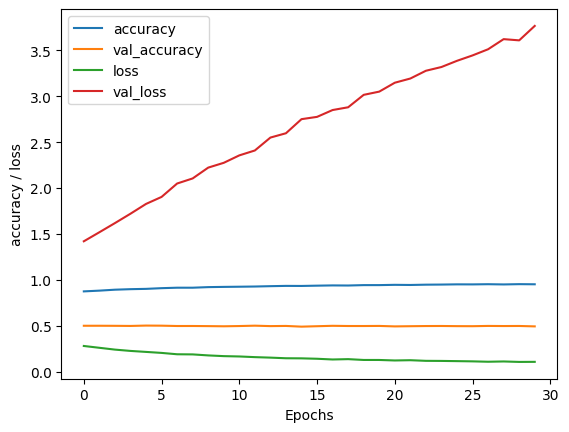

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string,str2):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.plot(history.history[str2])
  plt.plot(history.history['val_'+str2])
  plt.xlabel("Epochs")
  plt.ylabel(string+" / "+str2)
  plt.legend([string, 'val_'+string, str2, 'val_'+str2])
  plt.savefig('NNAccuracyLoss.pdf')

plot_graphs(history, "accuracy","loss")

# BERT MODEL

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import accuracy_score
import tensorflow as tf


Load the pre-trained BERT model and tokenizer

In [ ]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenize the input data

In [ ]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
x_train_tokens = tokenizer.batch_encode_plus(
    trainingReddits,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)
x_test_tokens = tokenizer.batch_encode_plus(
    testingReddits,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='tf'
)


Convert the tokenized inputs to TensorFlow datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x_train_tokens),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(x_test_tokens),
    y_test
))


Prepare the datasets for training and evaluation

In [ ]:
train_dataset = train_dataset.shuffle(len(x_train)).batch(32)
test_dataset = test_dataset.batch(32)


Compile and train the BERT model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_dataset, epochs=30)

Epoch 1/30
777/777 [==============================] - 272s 292ms/step - loss: 0.1508 - accuracy: 0.9399
Epoch 2/30
777/777 [==============================] - 211s 272ms/step - loss: 0.1185 - accuracy: 0.9548
Epoch 3/30
777/777 [==============================] - 209s 269ms/step - loss: 0.0957 - accuracy: 0.9641
Epoch 4/30
777/777 [==============================] - 209s 269ms/step - loss: 0.0784 - accuracy: 0.9713
Epoch 5/30
777/777 [==============================] - 209s 268ms/step - loss: 0.0711 - accuracy: 0.9745
Epoch 6/30
777/777 [==============================] - 208s 267ms/step - loss: 0.0594 - accuracy: 0.9788
Epoch 7/30
777/777 [==============================] - 208s 267ms/step - loss: 0.0540 - accuracy: 0.9807
Epoch 8/30
777/777 [==============================] - 208s 268ms/step - loss: 0.0527 - accuracy: 0.9807
Epoch 9/30
777/777 [==============================] - 207s 266ms/step - loss: 0.0464 - accuracy: 0.9833
Epoch 10/30
777/777 [==============================] - 207s 267m

Evaluate the model on the test set

In [ ]:
predictions = model.predict(test_dataset)
y_pred = tf.argmax(predictions.logits, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

260/260 [==============================] - 28s 96ms/step
Accuracy: 0.503800217155266
